<a href="https://colab.research.google.com/github/ShoaibMuhammad123/AICP-tasks/blob/main/MobileNet_Model_for_Ejection_Fraction_Prediction_using_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Gemini Pro**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import os


In [ ]:

# --- Configuration ---
IMG_SIZE = (224, 224) # Input size for the CNN model
BATCH_SIZE = 32
IMAGE_DIR = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/' # Path to your image folder
ECHO_FILE_PATH = '/content/drive/MyDrive/FYP/Ejection_Fraction_Values.csv' # Path to your CSV file


# --- Load the CSV file ---
# We assume the CSV has no header row and one column of echo values.
try:
    echo_df = pd.read_csv(ECHO_FILE_PATH, header=None, names=['ejection_fraction'])
    print(f"Successfully loaded {len(echo_df)} echo values from '{ECHO_FILE_PATH}'.")
except FileNotFoundError:
    print(f"Error: The file '{ECHO_FILE_PATH}' was not found. Please check the path.")
    exit()


Successfully loaded 678 echo values from '/content/drive/MyDrive/FYP/Ejection_Fraction_Values.csv'.


In [ ]:

# --- Create the full dataset DataFrame ---
num_images = len(echo_df)
# Generate the list of image filenames (1.PNG, 2.PNG, ...)
image_filenames = [f"{i+1}.PNG" for i in range(num_images)]

# Create the main DataFrame
df = pd.DataFrame({
    'image_filename': image_filenames,
    'ejection_fraction': echo_df['ejection_fraction']
})
df.head()

,image_filename,ejection_fraction
0,1.PNG,35
1,2.PNG,31
2,3.PNG,39
3,4.PNG,57
4,5.PNG,34


In [ ]:
df.shape

(678, 2)

In [ ]:

# --- Create full image paths ---
# This combines the directory path with the filename from the CSV
df['full_path'] = df['image_filename'].apply(lambda x: os.path.join(IMAGE_DIR, x))


In [ ]:
df.shape

(678, 3)

In [ ]:
df.head()

,image_filename,ejection_fraction,full_path
0,1.PNG,35,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...
1,2.PNG,31,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...
2,3.PNG,39,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...
3,4.PNG,57,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...
4,5.PNG,34,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...


In [ ]:

# --- Verification Step (This will now pass if the path is correct) ---
df['file_exists'] = df['full_path'].apply(os.path.exists)

if not df['file_exists'].all():
    print("\nError: Still can't find some image files!")
    print("Please double-check that your IMAGE_DIR is correct.")
    print("\nMissing files:")
    # Print the first 5 missing files for debugging
    print(df[~df['file_exists']]['full_path'].head().tolist())
    exit() # Stop the script if files are still missing
else:
    print(f"\nSuccess! Found and mapped all {len(df)} images.")
    print("Here's a sample of the data with correct paths:")
    print(df.head())


Success! Found and mapped all 678 images.
Here's a sample of the data with correct paths:
  image_filename  ejection_fraction  \
0          1.PNG                 35   
1          2.PNG                 31   
2          3.PNG                 39   
3          4.PNG                 57   
4          5.PNG                 34   

                                           full_path  file_exists  
0  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
1  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
2  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
3  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
4  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  


In [ ]:
df

,image_filename,ejection_fraction,full_path,file_exists
0,1.PNG,35,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
1,2.PNG,31,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
2,3.PNG,39,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
3,4.PNG,57,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
4,5.PNG,34,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
...,...,...,...,...
673,674.PNG,37,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
674,675.PNG,31,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
675,676.PNG,35,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True
676,677.PNG,33,/content/drive/MyDrive/FYP/Train/ECG_abnormal/...,True


In [ ]:
df.ejection_fraction.value_counts().head(5)

,count
ejection_fraction,
35,55
30,55
38,54
37,46
40,44


In [ ]:

# Extract the file paths and the labels (echo values)
image_paths = df['full_path'].values
labels = df['ejection_fraction'].values


In [ ]:
image_paths[:5]

array(['/content/drive/MyDrive/FYP/Train/ECG_abnormal/1.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/2.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/3.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/4.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/5.PNG'],
      dtype=object)

In [ ]:
labels[:5]

array([35, 31, 39, 57, 34])

In [ ]:

# Extract the file paths and the labels (echo values)
image_paths = df['full_path'].values
labels = df['ejection_fraction'].values

# First split: 80% for training/validation, 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Second split: Create a validation set from the training set
# Here, validation is 15% of the original 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 460
Validation samples: 82
Testing samples: 136


In [ ]:
X_test[:20]

array(['/content/drive/MyDrive/FYP/Train/ECG_abnormal/647.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/337.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/368.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/102.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/345.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/260.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/165.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/596.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/383.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/312.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/400.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/528.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/599.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/132.PNG',
       '/content/drive/MyDrive/FYP/Train/

In [ ]:

# --- Data Preprocessing Function ---
def load_and_preprocess_image(path, label):
    """
    Reads an image file, decodes it, resizes it, and normalizes the pixels.
    """
    # Read the file from the path
    image = tf.io.read_file(path)
    # Decode the image to a tensor (3 channels for color)
    # expand_animations=False is important for non-GIF files like PNG/JPG
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Resize to the model's expected input size
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    # Normalize pixel values from [0, 255] to [0, 1]
    image = image / 255.0
    return image, label


In [ ]:

# --- Create tf.data.Dataset objects ---
def create_dataset(X, y):
    """
    Turns file paths and labels into a batched and prefetched tf.data.Dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # Apply the preprocessing function in parallel
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle the data to ensure random order during training
    dataset = dataset.shuffle(buffer_size=len(X))
    # Group data into batches
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch batches for smoother training performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

# Let's inspect a single batch to confirm its shape
for images, labels in train_ds.take(1):
    print("\nShape of a batch of images:", images.shape)
    print("Shape of a batch of labels:", labels.shape)


Shape of a batch of images: (32, 224, 224, 3)
Shape of a batch of labels: (32,)


## Build the CNN Regression Model

In [ ]:
# --- Load the pre-trained base model ---
# include_top=False strips off the original classification layer
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet' # Use weights pre-trained on ImageNet
)

# Freeze the layers of the base model so they are not updated during initial training
base_model.trainable = False

# --- Add our custom regression head ---
x = base_model.output
x = GlobalAveragePooling2D()(x) # Averages the features
x = Dense(128, activation='relu')(x) # A dense layer for learning complex patterns
# The final output layer has one neuron for our single output value (echo).
# It has no activation function (or a 'linear' one) which is standard for regression.
predictions = Dense(1)(x)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# --- Create the final model ---
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:

# --- Compile the model ---
# For regression, 'mean_absolute_error' (MAE) is a great loss function.
# It measures the average absolute difference between predicted and actual values.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# --- Train the model ---
EPOCHS = 25 # You can adjust this number

# This callback will stop training if val_loss doesn't improve for 3 consecutive epochs
# and will restore the weights from the best epoch.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

print("\nTraining complete.")

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 29.1361 - mean_absolute_error: 29.1361 - mean_squared_error: 921.6603 - val_loss: 8.1675 - val_mean_absolute_error: 8.1675 - val_mean_squared_error: 95.5981
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 864ms/step - loss: 7.1667 - mean_absolute_error: 7.1667 - mean_squared_error: 79.6641 - val_loss: 6.3353 - val_mean_absolute_error: 6.3353 - val_mean_squared_error: 65.0036
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 864ms/step - loss: 5.9395 - mean_absolute_error: 5.9395 - mean_squared_error: 52.6846 - val_loss: 5.4739 - val_mean_absolute_error: 5.4739 - val_mean_squared_error: 47.7391
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 851ms/step - loss: 5.4013 - mean_absolute_error: 5.4013 - mean_squared_error: 46.1746 - val_loss: 5.2034 - val_mean_absolute_error: 5.2034 - val_mean_squared_error: 44.1449
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 997ms/step - loss: 4.7063 - mean_absolute_error: 4.7063 - mean_squared_error: 36.0908 - val_loss: 

# Evaluation Code

In [ ]:
# --- Evaluate the model on the test data ---
print("\nEvaluating model on the test set...")
results = model.evaluate(test_ds)

print(f"\nTest Loss (Mean Absolute Error): {results[1]:.2f}")
print(f"This means, on average, the model's prediction is off by ~{results[1]:.2f} EF points.")

# --- Make predictions on a few test samples ---
print("\n--- Example Predictions ---")
for test_images, test_labels in test_ds.take(1):
    predictions = model.predict(test_images)
    for i in range(min(15, BATCH_SIZE)): # Show up to 5 predictions
        actual = test_labels[i].numpy()
        predicted = predictions[i][0]
        print(f"   Actual EF: {actual:.1f}, Predicted EF: {predicted:.1f}")


Evaluating model on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 602ms/step - loss: 4.8899 - mean_absolute_error: 4.8899 - mean_squared_error: 35.2103

Test Loss (Mean Absolute Error): 4.99
This means, on average, the model's prediction is off by ~4.99 EF points.

--- Example Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
   Actual EF: 42.0, Predicted EF: 33.7
   Actual EF: 37.0, Predicted EF: 34.0
   Actual EF: 28.0, Predicted EF: 37.7
   Actual EF: 42.0, Predicted EF: 34.3
   Actual EF: 47.0, Predicted EF: 32.7
   Actual EF: 42.0, Predicted EF: 39.5
   Actual EF: 30.0, Predicted EF: 30.6
   Actual EF: 39.0, Predicted EF: 39.6
   Actual EF: 31.0, Predicted EF: 35.6
   Actual EF: 28.0, Predicted EF: 35.7
   Actual EF: 38.0, Predicted EF: 35.1
   Actual EF: 40.0, Predicted EF: 34.2
   Actual EF: 25.0, Predicted EF: 37.5
   Actual EF: 38.0, Predicted EF: 36.6
   Actual EF: 45.0, Predicted EF: 38.2


# **Passing a Single Image for Prediction**

In [ ]:
import tensorflow as tf
import numpy as np

# Make sure this matches the IMG_SIZE used during training
IMG_SIZE = (224, 224)

def predict_single_image(model, image_path):
    """
    Loads, preprocesses, and predicts the EF for a single ECG image.

    Args:
        model: The trained Keras model.
        image_path: The file path to the single image.

    Returns:
        The predicted Ejection Fraction value (float).
    """
    # 1. Load and preprocess the image
    # Read the file from disk
    img = tf.io.read_file(image_path)
    # Decode the image to a tensor
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    # Resize to the target dimensions
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    # Normalize pixel values to [0, 1]
    img = img / 255.0

    # 2. Add a batch dimension
    # The model expects a batch of images, so we add an axis.
    # Shape changes from (224, 224, 3) to (1, 224, 224, 3)
    image_batch = tf.expand_dims(img, axis=0)

    print(f"Image preprocessed. Final tensor shape: {image_batch.shape}")

    # 3. Make the prediction
    prediction = model.predict(image_batch)

    # 4. Extract and return the scalar prediction value
    # The model returns a 2D array, e.g., [[55.4]], so we extract the number.
    predicted_value = prediction[0][0]

    return predicted_value

In [ ]:
# This code goes AFTER your model training is complete.
# Assume your trained model is stored in the 'model' variable.

# --- How to Use It ---

# 1. Specify the path to the image you want to test
# IMPORTANT: Replace this with the actual path to one of your ECG images.
image_to_predict_path = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/100.PNG' # Example path

# 2. Call the function to get the prediction
predicted_ef = predict_single_image(model, image_to_predict_path)

# 3. Print the result
print("\n" + "="*30)
print(f"Image Path: {image_to_predict_path}")
print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
print("="*30)

Image preprocessed. Final tensor shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/100.PNG
Predicted Ejection Fraction: 35.29%


In [ ]:
# This code goes AFTER your model training is complete.
# Assume your trained model is stored in the 'model' variable.

# --- How to Use It ---

# 1. Specify the path to the image you want to test
# IMPORTANT: Replace this with the actual path to one of your ECG images.
image_to_predict_path = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/127.PNG' # Example path

# 2. Call the function to get the prediction
predicted_ef = predict_single_image(model, image_to_predict_path)

# 3. Print the result
print("\n" + "="*30)
print(f"Image Path: {image_to_predict_path}")
print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
print("="*30)

Image preprocessed. Final tensor shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/127.PNG
Predicted Ejection Fraction: 34.05%


In [ ]:
# This code goes AFTER your model training is complete.
# Assume your trained model is stored in the 'model' variable.

# --- How to Use It ---

# 1. Specify the path to the image you want to test
# IMPORTANT: Replace this with the actual path to one of your ECG images.
image_to_predict_path = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/423.PNG' # Example path

# 2. Call the function to get the prediction
predicted_ef = predict_single_image(model, image_to_predict_path)

# 3. Print the result
print("\n" + "="*30)
print(f"Image Path: {image_to_predict_path}")
print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
print("="*30)

Image preprocessed. Final tensor shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/423.PNG
Predicted Ejection Fraction: 37.55%


# **Saving The Model**

In [ ]:
import tensorflow as tf

# Assume your trained model is in a variable called 'model'

# --- 1. Define where to save the model on your Google Drive ---
# It's best to create a dedicated folder for your project models.
save_directory = '/content/drive/MyDrive/FYP/My_ECG_Project_EF/models/'
model_filename = 'ecg_ef_prediction_model_v1.keras' # Use the .keras extension

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Combine the directory and filename to get the full path
full_save_path = os.path.join(save_directory, model_filename)

# --- 2. Save the model ---
print(f"\nSaving model to: {full_save_path}...")
model.save(full_save_path)

print("✅ Model saved successfully!")


Saving model to: /content/drive/MyDrive/FYP/My_ECG_Project_EF/models/ecg_ef_prediction_model_v1.keras...
✅ Model saved successfully!


# **Loading the Model and Making Prediction with the saved Model**

In [ ]:
# from google.colab import drive
# import os

# # This will prompt you for authorization.
# drive.mount('/content/drive')

In [ ]:
import tensorflow as tf

# --- IMPORTANT: Update this path to where you saved your model ---
saved_model_path = '/content/drive/MyDrive/FYP/My_ECG_Project_EF/models/ecg_ef_prediction_model_v1.keras'

# Check if the file exists before trying to load it
if not os.path.exists(saved_model_path):
    print(f"Error: Model file not found at '{saved_model_path}'")
    print("Please make sure the path is correct.")
else:
    print(f"Loading model from: {saved_model_path}...")
    # Load the model, including its architecture, weights, and optimizer state
    loaded_model = tf.keras.models.load_model(saved_model_path)
    print("✅ Model loaded successfully!")

    # Optional: Display the model's architecture to confirm it loaded correctly
    loaded_model.summary()

Loading model from: /content/drive/MyDrive/FYP/My_ECG_Project_EF/models/ecg_ef_prediction_model_v1.keras...
✅ Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

# **Prepare the Prediction Function**

In [ ]:
import tensorflow as tf

# Define the image size your model expects
IMG_SIZE = (224, 224)

def predict_single_image(model, image_path):
    """
    Loads, preprocesses, and predicts the EF for a single ECG image.
    """
    try:
        # 1. Load and preprocess the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
        img = img / 255.0  # Normalize to [0, 1]

        # 2. Add a batch dimension (shape from (H, W, C) to (1, H, W, C))
        image_batch = tf.expand_dims(img, axis=0)

        # 3. Make the prediction
        prediction = model.predict(image_batch)

        # 4. Return the scalar prediction value
        return prediction[0][0]

    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")
        return None

# **Passing Test Data**

In [ ]:
# --- IMPORTANT: Change this to the path of the image you want to test ---
# Make sure this image is accessible, e.g., also on your Google Drive or uploaded to Colab.
image_to_predict_path = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG' # Example path

# Make sure the model is loaded before predicting
if 'loaded_model' in locals():
    # Call the function to get the prediction
    predicted_ef = predict_single_image(loaded_model, image_to_predict_path)

    # Display the result
    if predicted_ef is not None:
        print("\n" + "="*30)
        print(f"Image Path: {image_to_predict_path}")
        print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
        print("="*30)
else:
    print("\nModel is not loaded. Please run Step 2 successfully first.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG
Predicted Ejection Fraction: 32.85%


# **Passing Any Image**

In [ ]:
# --- IMPORTANT: Change this to the path of the image you want to test ---
# Make sure this image is accessible, e.g., also on your Google Drive or uploaded to Colab.
image_to_predict_path = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/202.PNG' # Example path

# Make sure the model is loaded before predicting
if 'loaded_model' in locals():
    # Call the function to get the prediction
    predicted_ef = predict_single_image(loaded_model, image_to_predict_path)

    # Display the result
    if predicted_ef is not None:
        print("\n" + "="*30)
        print(f"Image Path: {image_to_predict_path}")
        print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
        print("="*30)
else:
    print("\nModel is not loaded. Please run Step 2 successfully first.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/202.PNG
Predicted Ejection Fraction: 30.93%


# Testing

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:


# --- IMPORTANT: Update this path to where you saved your model ---
saved_model_path = '/content/drive/MyDrive/FYP/My_ECG_Project_EF/MobileNetV2_Model/ecg_ef_prediction_model_v1.keras'

# Check if the file exists before trying to load it
if not os.path.exists(saved_model_path):
    print(f"Error: Model file not found at '{saved_model_path}'")
    print("Please make sure the path is correct.")
else:
    print(f"Loading model from: {saved_model_path}...")
    # Load the model, including its architecture, weights, and optimizer state
    loaded_model = tf.keras.models.load_model(saved_model_path)
    print("✅ Model loaded successfully!")

    # Optional: Display the model's architecture to confirm it loaded correctly
    loaded_model.summary()

Loading model from: /content/drive/MyDrive/FYP/My_ECG_Project_EF/MobileNetV2_Model/ecg_ef_prediction_model_v1.keras...
✅ Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

# **Image Preprocessing Before Prediction**

In [ ]:

# Define the image size your model expects
IMG_SIZE = (224, 224)

def predict_single_image(model, image_path):
    """
    Loads, preprocesses, and predicts the EF for a single ECG image.
    """
    try:
        # 1. Load and preprocess the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
        img = img / 255.0  # Normalize to [0, 1]

        # 2. Add a batch dimension (shape from (H, W, C) to (1, H, W, C))
        image_batch = tf.expand_dims(img, axis=0)

        # 3. Make the prediction
        prediction = model.predict(image_batch)

        # 4. Return the scalar prediction value
        return prediction[0][0]

    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")
        return None

# **Passing Test Image**

In [ ]:
# --- IMPORTANT: Change this to the path of the image you want to test ---
# Make sure this image is accessible, e.g., also on your Google Drive or uploaded to Colab.
image_to_predict_path = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG' # Example path

# Make sure the model is loaded before predicting
if 'loaded_model' in locals():
    # Call the function to get the prediction
    predicted_ef = predict_single_image(loaded_model, image_to_predict_path)

    # Display the result
    if predicted_ef is not None:
        print("\n" + "="*30)
        print(f"Image Path: {image_to_predict_path}")
        print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
        print("="*30)
else:
    print("\nModel is not loaded. Please run Step 2 successfully first.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG
Predicted Ejection Fraction: 32.85%


In [ ]:
X_test[:6]

array(['/content/drive/MyDrive/FYP/Train/ECG_abnormal/647.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/337.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/368.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/102.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/345.PNG'],
      dtype=object)

In [ ]:
preds = []

for img in X_test:
  image_to_predict_path = img # Example path

  # Make sure the model is loaded before predicting
  if 'loaded_model' in locals():
      # Call the function to get the prediction
      predicted_ef = predict_single_image(loaded_model, image_to_predict_path)
      preds.append(predicted_ef)
      # Display the result
      # if predicted_ef is not None:
      #     print("\n" + "="*30)
      #     print(f"Image Path: {image_to_predict_path}")
      #     print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
      #     print("="*30)
  else:
      print("\nModel is not loaded. Please run Step 2 successfully first.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━

In [ ]:
# get prediction for all test images and store in list also make a list for original labels

preds

[np.float32(32.40076),
 np.float32(35.712),
 np.float32(32.8525),
 np.float32(36.125927),
 np.float32(32.668682),
 np.float32(36.58227)]

In [ ]:
y_test

array([35, 28, 28, 27, 24, 30, 38, 38, 35, 33, 45, 36, 33, 27, 26, 25, 36,
       30, 37, 27, 39, 29, 25, 33, 36, 39, 30, 47, 35, 30, 30, 40, 27, 30,
       34, 37, 39, 38, 37, 40, 37, 30, 30, 25, 38, 40, 42, 31, 42, 45, 39,
       31, 42, 30, 35, 43, 28, 42, 30, 39, 38, 33, 30, 30, 43, 37, 39, 39,
       38, 32, 38, 36, 40, 35, 35, 31, 28, 36, 38, 31, 30, 40, 32, 25, 38,
       48, 38, 33, 35, 28, 37, 40, 40, 42, 28, 44, 36, 31, 43, 44, 36, 34,
       35, 45, 42, 30, 37, 35, 42, 37, 42, 29, 33, 33, 38, 45, 48, 47, 36,
       46, 33, 28, 35, 40, 43, 40, 38, 27, 26, 45, 28, 42, 40, 36, 40, 35])

In [ ]:
# convert into a single dimention array
y_p = np.array(preds)
y_p

array([32.40076 , 35.712   , 32.8525  , 36.125927, 32.668682, 36.58227 ,
       37.46183 , 35.07116 , 38.40451 , 32.641235, 35.440796, 37.493458,
       30.504707, 34.383408, 37.664227, 37.500835, 35.858505, 39.26736 ,
       38.135456, 37.46703 , 39.55465 , 34.481087, 33.74434 , 28.273876,
       38.812393, 37.505535, 36.70325 , 32.699356, 36.286053, 33.588852,
       37.64236 , 35.43958 , 35.52984 , 34.79546 , 42.245697, 34.52204 ,
       34.72509 , 34.719944, 32.641758, 35.867218, 34.314655, 30.63749 ,
       32.3996  , 36.083668, 36.557053, 35.55008 , 34.33519 , 35.851467,
       32.40408 , 32.59108 , 39.239887, 35.6106  , 32.559265, 34.48299 ,
       37.720142, 38.678757, 36.837574, 33.295467, 35.33996 , 36.574272,
       37.267406, 35.685715, 32.10064 , 35.091946, 37.234386, 34.024563,
       37.016144, 34.831585, 33.32994 , 36.996445, 35.007412, 30.716148,
       34.373657, 33.89516 , 40.708675, 34.182926, 31.822523, 37.763107,
       34.05788 , 35.52285 , 34.766155, 38.22575 , 

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

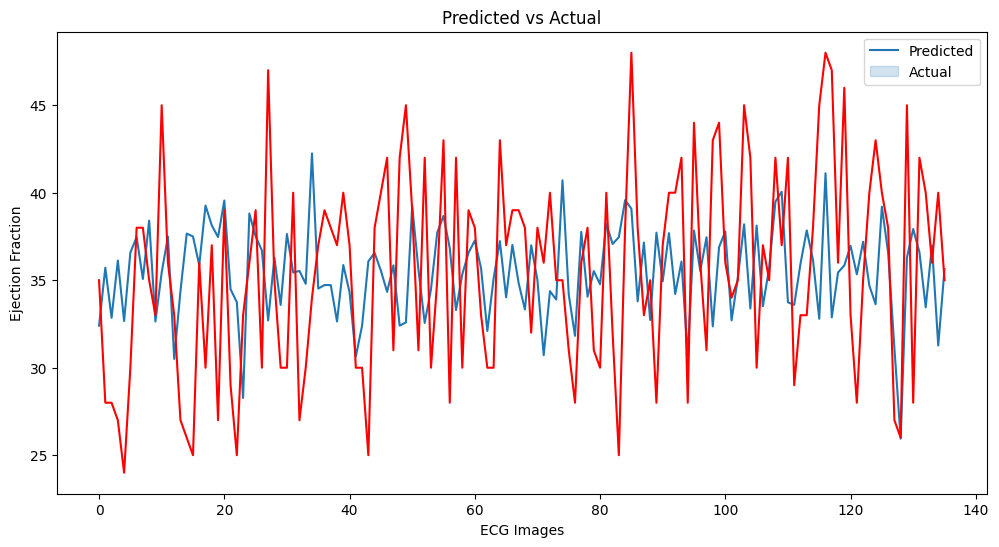

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(y_p)
sns.lineplot(y_test,color='red')
plt.legend(['Predicted','Actual'])
plt.xlabel('ECG Images')
plt.ylabel('Ejection Fraction')
plt.title('Predicted vs Actual')
plt.show()


In [ ]:
y_test
# sort the array
# sorted(y_test)

array([35, 28, 28, 27, 24, 30, 38, 38, 35, 33, 45, 36, 33, 27, 26, 25, 36,
       30, 37, 27, 39, 29, 25, 33, 36, 39, 30, 47, 35, 30, 30, 40, 27, 30,
       34, 37, 39, 38, 37, 40, 37, 30, 30, 25, 38, 40, 42, 31, 42, 45, 39,
       31, 42, 30, 35, 43, 28, 42, 30, 39, 38, 33, 30, 30, 43, 37, 39, 39,
       38, 32, 38, 36, 40, 35, 35, 31, 28, 36, 38, 31, 30, 40, 32, 25, 38,
       48, 38, 33, 35, 28, 37, 40, 40, 42, 28, 44, 36, 31, 43, 44, 36, 34,
       35, 45, 42, 30, 37, 35, 42, 37, 42, 29, 33, 33, 38, 45, 48, 47, 36,
       46, 33, 28, 35, 40, 43, 40, 38, 27, 26, 45, 28, 42, 40, 36, 40, 35])

In [ ]:
df1 = pd.DataFrame({'Actual':y_test,'Predicted':y_p})

In [ ]:
df1

,Actual,Predicted
0,35,32.400761
1,28,35.712002
2,28,32.852501
3,27,36.125927
4,24,32.668682
...,...,...
131,42,36.591740
132,40,33.452633
133,36,36.985924
134,40,31.269882


In [ ]:
# sort on basis of actual
df1.sort_values('Actual',inplace=True)

In [ ]:
df1.head(40)

,Actual,Predicted
4,24,32.668682
15,25,37.500835
22,25,33.744339
43,25,36.083668
83,25,37.457893
14,26,37.664227
128,26,25.946861
19,27,37.467030
32,27,35.529839
3,27,36.125927


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 4 to 85
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Actual     136 non-null    int64  
 1   Predicted  136 non-null    float32
dtypes: float32(1), int64(1)
memory usage: 6.7 KB


In [ ]:
df1['Actual'].nunique()

24

In [ ]:
df1['Actual'].unique()

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       42, 43, 44, 45, 46, 47, 48])

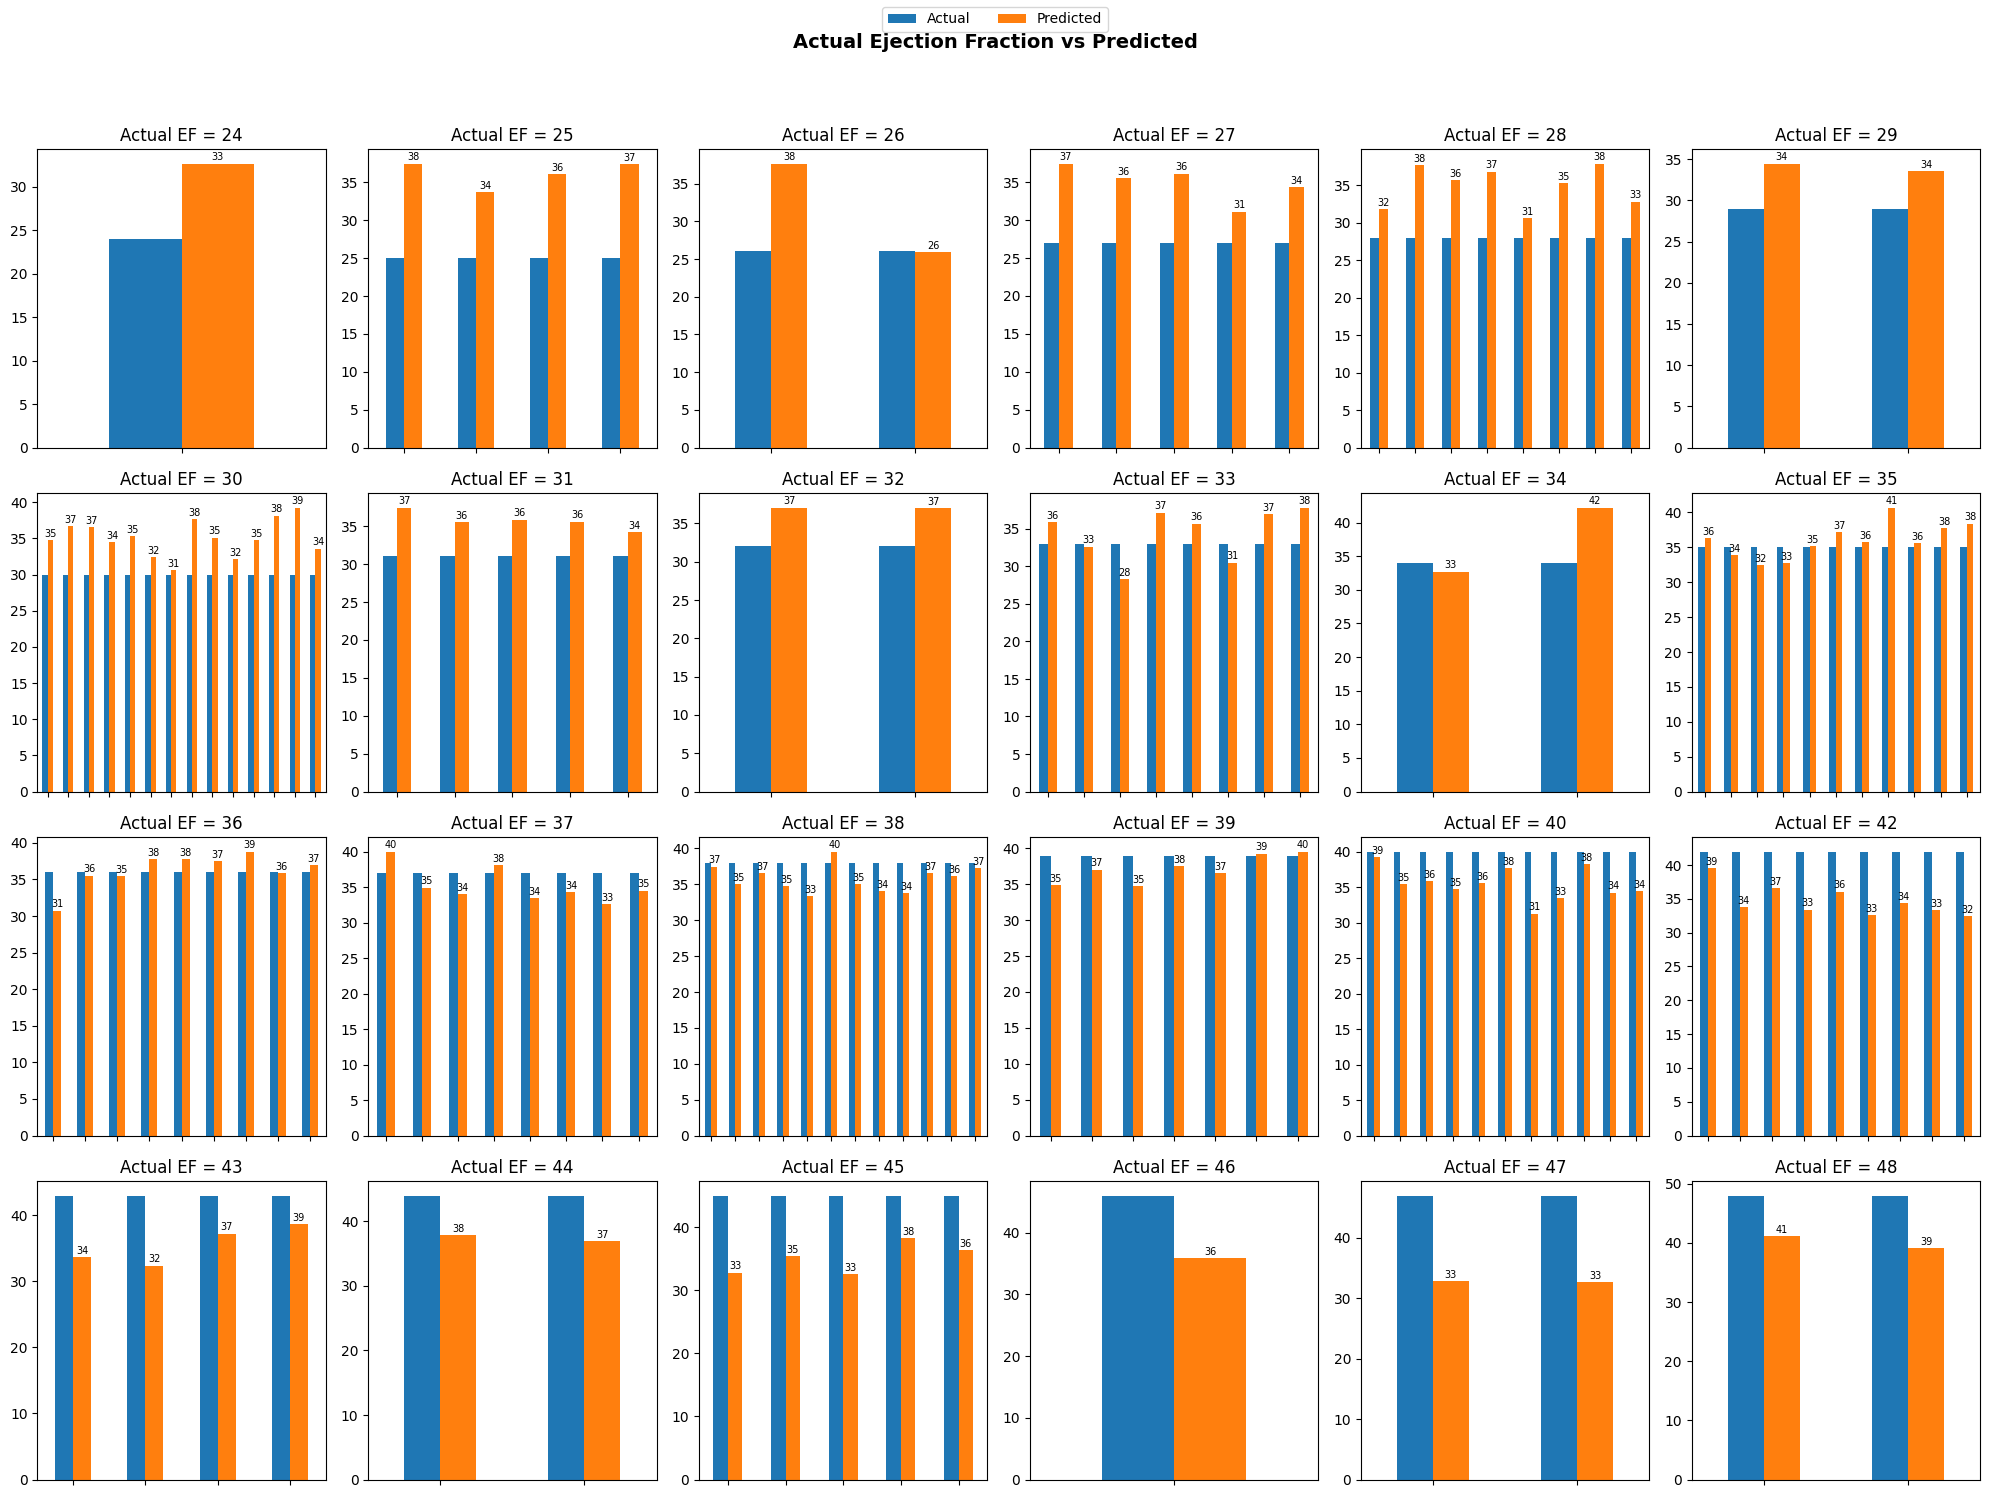

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6, figsize=(20, 15))
r_ind, c_ind = 0, 0

for i in df1['Actual'].unique():
    subset = df1[df1['Actual'] == i]
    bars = subset.plot(kind='bar', ax=ax[r_ind, c_ind], legend=False, title=f"Actual EF = {i}")

    # Remove x-axis tick labels
    ax[r_ind, c_ind].set_xticklabels([])

    # Add predicted values only
    for container, label in zip(bars.containers, bars.get_legend_handles_labels()[1]):
        if label.lower() == 'predicted':  # show only for predicted bars
            bars.bar_label(container, labels=[f"{v:.0f}" for v in container.datavalues],
                           fontsize=7, label_type='edge', padding=1)

    c_ind += 1
    if c_ind > 5:
        c_ind = 0
        r_ind += 1

# Add one common legend for all subplots
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels))
fig.suptitle("Actual Ejection Fraction vs Predicted", fontsize=14, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# **Using Emotion Detection Model**

In [ ]:


# --- Configuration ---
IMG_SIZE = (224, 224) # Input size for the CNN model
BATCH_SIZE = 32
IMAGE_DIR = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/' # Path to your image folder
ECHO_FILE_PATH = '/content/drive/MyDrive/FYP/Ejection_Fraction_Values.csv' # Path to your CSV file


# --- Load the CSV file ---
# We assume the CSV has no header row and one column of echo values.
try:
    echo_df = pd.read_csv(ECHO_FILE_PATH, header=None, names=['ejection_fraction'])
    print(f"Successfully loaded {len(echo_df)} echo values from '{ECHO_FILE_PATH}'.")
except FileNotFoundError:
    print(f"Error: The file '{ECHO_FILE_PATH}' was not found. Please check the path.")
    exit()

# --- Create the full dataset DataFrame ---
num_images = len(echo_df)
# Generate the list of image filenames (1.PNG, 2.PNG, ...)
image_filenames = [f"{i+1}.PNG" for i in range(num_images)]

# Create the main DataFrame
df = pd.DataFrame({
    'image_filename': image_filenames,
    'ejection_fraction': echo_df['ejection_fraction']
})

# --- Create full image paths ---
# This combines the directory path with the filename from the CSV
df['full_path'] = df['image_filename'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# --- Verification Step (This will now pass if the path is correct) ---
df['file_exists'] = df['full_path'].apply(os.path.exists)

if not df['file_exists'].all():
    print("\nError: Still can't find some image files!")
    print("Please double-check that your IMAGE_DIR is correct.")
    print("\nMissing files:")
    # Print the first 5 missing files for debugging
    print(df[~df['file_exists']]['full_path'].head().tolist())
    exit() # Stop the script if files are still missing
else:
    print(f"\nSuccess! Found and mapped all {len(df)} images.")
    print("Here's a sample of the data with correct paths:")
    print(df.head())
# Extract the file paths and the labels (echo values)
image_paths = df['full_path'].values
labels = df['ejection_fraction'].values


# First split: 80% for training/validation, 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Second split: Create a validation set from the training set
# Here, validation is 15% of the original 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")
# --- Data Preprocessing Function ---
def load_and_preprocess_image(path, label):
    """
    Reads an image file, decodes it, resizes it, and normalizes the pixels.
    """
    # Read the file from the path
    image = tf.io.read_file(path)
    # Decode the image to a tensor (3 channels for color)
    # expand_animations=False is important for non-GIF files like PNG/JPG
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Resize to the model's expected input size
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    # Normalize pixel values from [0, 255] to [0, 1]
    image = image / 255.0
    return image, label

# --- Create tf.data.Dataset objects ---
def create_dataset(X, y):
    """
    Turns file paths and labels into a batched and prefetched tf.data.Dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # Apply the preprocessing function in parallel
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle the data to ensure random order during training
    dataset = dataset.shuffle(buffer_size=len(X))
    # Group data into batches
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch batches for smoother training performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

# Let's inspect a single batch to confirm its shape
for images, labels in train_ds.take(1):
    print("\nShape of a batch of images:", images.shape)
    print("Shape of a batch of labels:", labels.shape)

Successfully loaded 678 echo values from '/content/drive/MyDrive/FYP/Ejection_Fraction_Values.csv'.

Success! Found and mapped all 678 images.
Here's a sample of the data with correct paths:
  image_filename  ejection_fraction  \
0          1.PNG                 35   
1          2.PNG                 31   
2          3.PNG                 39   
3          4.PNG                 57   
4          5.PNG                 34   

                                           full_path  file_exists  
0  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
1  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
2  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
3  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  
4  /content/drive/MyDrive/FYP/Train/ECG_abnormal/...         True  

Training samples: 460
Validation samples: 82
Testing samples: 136

Shape of a batch of images: (32, 224, 224, 3)
Shape of a batch of labels: (32,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# --- This code replaces your original model-building section ---

# 1. Load the base model as before
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Start with all layers frozen

# 2. Add your custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1)(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 3. COMPILE AND TRAIN THE HEAD FIRST (just as you did before)
print("--- Phase 1: Training the top layer ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)
# --- FIX IS HERE: Define the callback before using it ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=10, # Train the head for a few epochs
    validation_data=val_ds,
    callbacks=[early_stopping]
)


--- Phase 1: Training the top layer ---
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 25.5042 - mean_absolute_error: 25.5042 - val_loss: 6.5948 - val_mean_absolute_error: 6.5948
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 7.3878 - mean_absolute_error: 7.3878 - val_loss: 5.4465 - val_mean_absolute_error: 5.4465
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 5.7887 - mean_absolute_error: 5.7887 - val_loss: 5.3267 - val_mean_absolute_error: 5.3267
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 5.3899 - mean_absolute_error: 5.3899 - val_loss: 5.5184 - val_mean_absolute_error: 5.5184
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 5.4629 - mean_absolute_error: 5.4629 - val_loss: 5.1143 - val_mean_absolute_error: 5.1143
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 4.7204 - mean_absolute_error: 4.7204 - val_loss: 5.0790 - val_mean_absolute_error: 5.0790
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 

# 4.**UNFREEZE a portion of the base model**

In [ ]:


print("\n--- Phase 2: Fine-tuning the model ---")
base_model.trainable = True

# Let's unfreeze the top 30 layers. You can experiment with this number.
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 5. RE-COMPILE with a very low learning rate
# A low learning rate is crucial for fine-tuning to prevent destroying the pre-trained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Very low learning rate
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

# --- FIX IS HERE: Define the callback before using it ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# 6. CONTINUE TRAINING (Fine-tuning)
history_fine_tune = model.fit(
    train_ds,
    epochs=15, # Continue for more epochs
    validation_data=val_ds,
    callbacks=[early_stopping]
)


--- Phase 2: Fine-tuning the model ---
Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 8.9462 - mean_absolute_error: 8.9462 - val_loss: 7.8352 - val_mean_absolute_error: 7.8352
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 8.4517 - mean_absolute_error: 8.4517 - val_loss: 8.2906 - val_mean_absolute_error: 8.2906
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 7.7327 - mean_absolute_error: 7.7327 - val_loss: 8.6147 - val_mean_absolute_error: 8.6147
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 6.7848 - mean_absolute_error: 6.7848 - val_loss: 8.9347 - val_mean_absolute_error: 8.9347
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 6.3377 - mean_absolute_error: 6.3377 - val_loss: 9.0484 - val_mean_absolute_error: 9.0484


# Method 3 Data Augumentatiion

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [ ]:


## ------------------- 1. CONFIGURATION -------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMAGE_DIR = 'ECG/' # The folder containing your images
ECHO_FILE_PATH = 'f1.csv' # Your file with the echo values

## ------------------- 2. DATA LOADING AND MAPPING -------------------
try:
    echo_df = pd.read_csv(ECHO_FILE_PATH, header=None, names=['ejection_fraction'])
    print(f"Successfully loaded {len(echo_df)} echo values from '{ECHO_FILE_PATH}'.")
except FileNotFoundError:
    print(f"Error: The file '{ECHO_FILE_PATH}' was not found. Please check the path.")
    exit()

num_images = len(echo_df)
image_filenames = [f"{i+1}.PNG" for i in range(num_images)]

df = pd.DataFrame({
    'image_filename': image_filenames,
    'ejection_fraction': echo_df['ejection_fraction']
})
df['full_path'] = df['image_filename'].apply(lambda x: os.path.join(IMAGE_DIR, x))
df['file_exists'] = df['full_path'].apply(os.path.exists)

if not df['file_exists'].all():
    print("\nWarning: Some expected image files are missing!")
    df = df[df['file_exists']].copy()

print(f"\nSuccessfully mapped {len(df)} images to their echo values.")

## ------------------- 3. DATA SPLITTING -------------------
image_paths = df['full_path'].values
labels = df['ejection_fraction'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")


In [ ]:

## ------------------- 4. DATA AUGMENTATION & PREPROCESSING PIPELINE -------------------

# Define the data augmentation layers
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomContrast(0.1),
], name="data_augmentation")

# Define the preprocessing function
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    image = image / 255.0
    return image, label

# Create the master dataset function
def create_dataset(X, y, is_training=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # Apply preprocessing first
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation ONLY if it's the training dataset
    if is_training:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                               num_parallel_calls=tf.data.AUTOTUNE)

    # Standard steps for all datasets
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the final datasets
train_ds = create_dataset(X_train, y_train, is_training=True)
val_ds = create_dataset(X_val, y_val) # No augmentation on validation set
test_ds = create_dataset(X_test, y_test) # No augmentation on test set


In [ ]:

## ------------------- 5. MODEL BUILDING -------------------
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1)(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

## ------------------- 6. MODEL TRAINING -------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Increased patience a bit as augmentation can make val_loss fluctuate
    restore_best_weights=True
)

EPOCHS = 50 # You can often train for more epochs with augmentation

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

print("\nTraining complete.")


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 932ms/step - loss: 23.0989 - mean_absolute_error: 23.0989 - val_loss: 5.8261 - val_mean_absolute_error: 5.8261
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 8.0953 - mean_absolute_error: 8.0953 - val_loss: 8.6243 - val_mean_absolute_error: 8.6243
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 5.5003 - mean_absolute_error: 5.5003 - val_loss: 6.1863 - val_mean_absolute_error: 6.1863
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 5.4873 - mean_absolute_error: 5.4873 - val_loss: 6.0475 - val_mean_absolute_error: 6.0475
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 5.1284 - mean_absolute_error: 5.1284 - val_loss: 6.2588 - val_mean_absolute_error: 6.2588
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 4.9066 - mean_absolute_error: 4.9066 - val_loss: 5.3686 - val_mean_absolute_error: 5.3686
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 5.4188 - mean_absolute_error: 5


Evaluating model on the test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 5.4969 - mean_absolute_error: 5.4969

Test Loss (Mean Absolute Error): 5.07

--- Plotting Training History ---


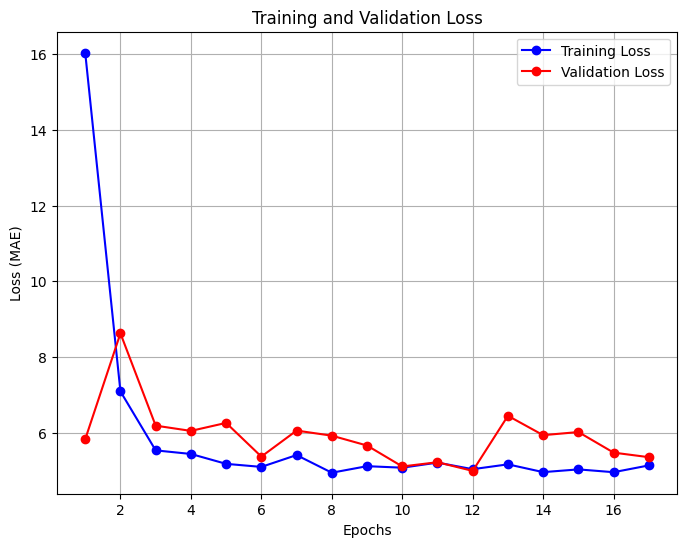

In [ ]:

## ------------------- 7. EVALUATION AND VISUALIZATION -------------------
print("\nEvaluating model on the test set...")
results = model.evaluate(test_ds)
print(f"\nTest Loss (Mean Absolute Error): {results[1]:.2f}")

# Plotting training history
print("\n--- Plotting Training History ---")
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Make sure this IMG_SIZE matches the one used for training.
IMG_SIZE = (224, 224)

def predict_ecg_image(model, image_path):
    """
    Loads, preprocesses, and predicts the Ejection Fraction for a single ECG image.

    Args:
        model: The trained Keras model.
        image_path: The file path to the single image you want to predict.

    Returns:
        The predicted Ejection Fraction value as a float.
    """
    try:
        # 1. Load the image file and decode it into a tensor.
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)

        # 2. Resize the image to the model's expected input size.
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])

        # 3. Normalize the pixel values to be in the [0, 1] range.
        img = img / 255.0

        # 4. Add a batch dimension. The model expects input of shape (1, H, W, C).
        image_batch = tf.expand_dims(img, axis=0)

        # 5. Make the prediction.
        prediction = model.predict(image_batch)

        # 6. Extract the scalar value from the prediction output (which is [[value]]).
        predicted_value = prediction[0][0]

        return predicted_value

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [ ]:
X_test[:4]

array(['/content/drive/MyDrive/FYP/Train/ECG_abnormal/647.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/337.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/64.PNG',
       '/content/drive/MyDrive/FYP/Train/ECG_abnormal/368.PNG'],
      dtype=object)

In [ ]:
# --- Example Usage ---

# 1. Specify the path to the image you want to predict.
#    (Replace with a real path to one of your ECG images)
path_to_my_image =   '/content/drive/MyDrive/FYP/Train/ECG_abnormal/102.PNG'

# 2. Call the function with your trained model and the image path.
predicted_ef = predict_ecg_image(model, path_to_my_image)

# 3. Print the result in a clean format.
if predicted_ef is not None:
    print("\n" + "="*35)
    print("      Model Prediction Result")
    print("="*35)
    print(f"Image Path: {path_to_my_image}")
    print(f"Predicted Ejection Fraction: {predicted_ef:.2f}%")
    print("="*35)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

      Model Prediction Result
Image Path: /content/drive/MyDrive/FYP/Train/ECG_abnormal/102.PNG
Predicted Ejection Fraction: 31.89%


## **Data Augumentation Gives us an MAE of 5.07**

# ***Hyper parameter Tuning of MobileNet Model***

In [ ]:
# pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import os
import keras_tuner as kt # Import the KerasTuner library

## ------------------- 1. CONFIGURATION -------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMAGE_DIR = '/content/drive/MyDrive/FYP/Train/ECG_abnormal/' # Path to your image folder
ECHO_FILE_PATH = '/content/drive/MyDrive/FYP/Ejection_Fraction_Values.csv' # Path to your CSV file


In [ ]:

## ------------------- 5. HYPERMODEL DEFINITION -------------------
# This function builds the model and defines the hyperparameters we want to tune.
def build_model(hp):
    # Load the pre-trained base model
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False # Keep base model frozen during the search

    # --- Define Hyperparameters to Tune ---
    # 1. Number of neurons in the dense layer
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)

    # 2. Learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # 3. Activation function
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    # --- Build the model with the chosen hyperparameters ---
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=hp_units, activation=hp_activation)(x) # Use tuned values
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), # Use tuned LR
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )
    return model


In [ ]:

## ------------------- 6. TUNER SETUP AND SEARCH -------------------
# Initialize the tuner. RandomSearch is a good, simple choice.
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_absolute_error', # The metric to minimize
    max_trials=10, # Total number of different hyperparameter combinations to test
    executions_per_trial=2, # How many times to train each combination (for stability)
    directory='keras_tuner_dir',
    project_name='ECG_EF_Prediction'
)

# A callback to stop training early if a trial is not improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

print("\n--- Starting Hyperparameter Search ---")
# This will take a while as it trains multiple models.
tuner.search(train_ds, epochs=20, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Hyperparameter Search Complete ---")
print(f"""
The optimal number of units in the dense layer is {best_hps.get('units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal activation function is {best_hps.get('activation')}.
""")

## ------------------- 7. RETRAIN BEST MODEL & EVALUATE -------------------
# Build the model with the optimal hyperparameters and train it on the full data for longer.
print("\n--- Training the Best Model Found by Tuner ---")
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_ds,
    epochs=50, # Train for more epochs
    validation_data=val_ds,
    callbacks=[stop_early]
)

print("\n--- Final Evaluation on Test Set ---")
results = best_model.evaluate(test_ds)
print(f"Test MAE of the best model: {results[1]:.2f}")

Trial 10 Complete [00h 10m 13s]
val_mean_absolute_error: 17.206558227539062

Best val_mean_absolute_error So Far: 4.5452916622161865
Total elapsed time: 01h 12m 55s

--- Hyperparameter Search Complete ---

The optimal number of units in the dense layer is 128.
The optimal learning rate for the optimizer is 0.01.
The optimal activation function is tanh.


--- Training the Best Model Found by Tuner ---
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 913ms/step - loss: 20.8479 - mean_absolute_error: 20.8479 - val_loss: 6.0882 - val_mean_absolute_error: 6.0882
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - loss: 5.3603 - mean_absolute_error: 5.3603 - val_loss: 5.3557 - val_mean_absolute_error: 5.3557
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 5.2540 - mean_absolute_error: 5.2540 - val_loss: 4.8676 - val_mean_absolute_error: 4.8676
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 5.0390 - mean_absolute_error: 5.0390 - val_loss: 4.5644 - val_mean_absolute_erro